In [240]:
import os
import sys
import xarray as xr
import numpy as np
from numpy import unravel_index
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.font_manager import FontProperties
from datetime import datetime
from pathlib import Path
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle

from scipy.ndimage import gaussian_filter

import warnings

In [2]:
warnings.filterwarnings('ignore')

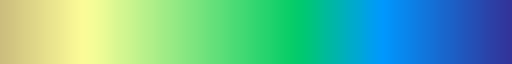

In [219]:
colors2 = plt.cm.terrain_r(np.linspace(0.4, 1, 45))
colors = np.vstack((colors2))
mixedmap = LinearSegmentedColormap.from_list('my_colormap', colors)
mixedmap

In [4]:
stats_dir = Path('/scratch/wmtsai/temp_mcs/output_stats/cape_subsat_hist/')

In [301]:
%%time
year_list = np.arange(2011,2021)
ds_list = []
for n,year in enumerate(year_list):
    tmp = xr.open_dataset(stats_dir / 'hist2d_cape_subsat_dtype.{}.ocean.omega850.full.nc'.format(year))
    #tmp2 = xr.open_dataset(stats_dir / 'hist2d_cape_subsat_dtype.{}.land.omega400.full.nc'.format(year))
    ds_list.append(tmp)
# merge all data
ds_merged_omega = xr.concat(ds_list, pd.Index(year_list, name='year'))

ds_list = []
for n,year in enumerate(np.arange(2011,2021)):
    tmp = xr.open_dataset(stats_dir / 'hist2d_cape_subsat_dtype.{}.ocean.precip.bins0.5.nc'.format(year))
    #tmp2 = xr.open_dataset(stats_dir / 'hist2d_cape_subsat_dtype.{}.land.precip.bins0.5.nc'.format(year))
    ds_list.append(tmp)
# merge all data
ds_merged_precip = xr.concat(ds_list, pd.Index(np.arange(2011,2021), name='year'))

CPU times: user 170 ms, sys: 55.8 ms, total: 226 ms
Wall time: 226 ms


#### MCS core-cold fraction at different MCS life stages

In [6]:
dir_stats = Path('/scratch/wmtsai/temp_mcs/mcs_stats/mcs_tracks_non2mcs')

core_frac_sum = np.zeros(5)
samples = 0
core_frac_init = []
core_frac_grow = []
core_frac_mature = []
core_frac_decay = []
core_frac_end = []

for year in year_list:
    
    ds_stats = xr.open_dataset(dir_stats / 'mcs_tracks_non2mcs_{}.tropics30NS.full.nc'.format(year))
    idt_mcs_init = ds_stats.idt_mcs_init
    landsea_flag = ds_stats.isel(times=idt_mcs_init).landsea_flag
    idx_oce = np.where(landsea_flag == 0)[0]
    ds_tracks_oce = ds_stats.isel(tracks=idx_oce) # filtering out MCSs initiated over oceans

    # calculate core/cold cloud fraction
    core_area = ds_tracks_oce.core_area
    ccs_area = ds_tracks_oce.ccs_area
    ds_tracks_oce['core_frac'] = core_area/ccs_area
    
    for track in ds_tracks_oce.tracks.values:
        
        ds_sub = ds_tracks_oce.sel(tracks=track)
        idt_mcs_phase = [ds_sub.idt_mcs_init, ds_sub.idt_mcs_grow, ds_sub.idt_mcs_mature,
                         ds_sub.idt_mcs_decay, ds_sub.idt_mcs_end]
        core_frac_phases = ds_sub.core_frac.isel(times=idt_mcs_phase).values
        core_frac_init.extend([core_frac_phases[0]])
        core_frac_grow.extend([core_frac_phases[1]])
        core_frac_mature.extend([core_frac_phases[2]])
        core_frac_decay.extend([core_frac_phases[3]])
        core_frac_end.extend([core_frac_phases[4]])
    
    

In [7]:
core_frac_mean = [np.mean(core_frac_init), np.mean(core_frac_grow), np.mean(core_frac_mature),
                  np.mean(core_frac_decay), np.mean(core_frac_end)]

#### 2D BL histogram based on MCS grids during MCS phases
- mcs: sampling mcs grids
- over ocean

In [300]:
# read climatology data
out_dir = Path('/scratch/wmtsai/temp_mcs/output_stats/cape_subsat_clim')
files = out_dir.glob('hist2d_cape_subsat_dtype.climatology.PrecOmega850.ocean*.bins0.5.nc')
for n,file in enumerate(files):
    if n == 0:
        ds_clim = xr.open_dataset(file)
    else:
        ds_clim += xr.open_dataset(file)

samples = ds_clim.samples
prec_sum = ds_clim.prec_sum
omega_sum = ds_clim.omega_sum
jointpdf_clim = samples/samples.sum()
prec_cond_clim = prec_sum/samples
prec_cond_clim = prec_cond_clim.where(jointpdf_clim > 1e-5)
omega_cond_clim = omega_sum/samples
omega_cond_clim = omega_cond_clim.where(jointpdf_clim > 1e-5)

In [258]:
ds_clim

<xarray.Dataset> Size: 70kB
Dimensions:      (bins_cape: 49, bins_subsat: 59)
Coordinates:
  * bins_cape    (bins_cape) float64 392B -15.0 -14.5 -14.0 ... 8.0 8.5 9.0
  * bins_subsat  (bins_subsat) float64 472B -5.0 -4.5 -4.0 ... 23.0 23.5 24.0
Data variables:
    samples      (bins_cape, bins_subsat) float64 23kB 0.0 0.0 0.0 ... 0.0 0.0
    omega_sum    (bins_cape, bins_subsat) float64 23kB 0.0 0.0 0.0 ... 0.0 0.0
    prec_sum     (bins_cape, bins_subsat) float64 23kB 0.0 0.0 0.0 ... 0.0 0.0

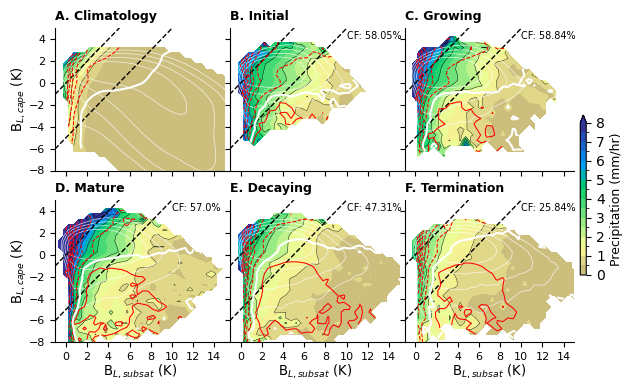

In [307]:
ds_merged_mcs = ds_merged_omega.sel(area_type='mcs').sum(('duration_type','year'))
prec_merged_mcs = ds_merged_precip.sel(area_type='mcs').sum(('duration_type','year'))
dbl = 0.5
ds_merged_mcs = ds_merged_mcs.interp(bins_cape=np.arange(bins_cape[0],bins_cape[-1]+dbl,dbl),
                                    bins_subsat=np.arange(bins_subsat[0],bins_subsat[-1]+dbl,dbl))
prec_merged_mcs = prec_merged_mcs.interp(bins_cape=np.arange(bins_cape[0],bins_cape[-1]+dbl,dbl),
                                    bins_subsat=np.arange(bins_subsat[0],bins_subsat[-1]+dbl,dbl))

cmap_norm = mixedmap
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(6,4))
phase_str = ['Initial','Growing','Mature','Decaying','Termination']

for p,(ax,phase,label_str,phase_str) in enumerate(zip([ax2,ax3,ax4,ax5,ax6]
                                        ,['Initial','Grow','Mature','Decay','End']
                                        ,['B.','C.','D.','E.','F.'],
                                        phase_str)):
   
    samples_sub = ds_merged_mcs.samples.sel(phase=phase)
    joint_prob = samples_sub/np.sum(samples_sub)
    omega_sub = ds_merged_mcs.omega_ltmean_sum.sel(phase=phase)
    omega_cond_sub = omega_sub/samples_sub
    omega_cond_mask = omega_cond_sub.where(samples_sub > 50)

    samples_sub = prec_merged_mcs.samples.sel(phase=phase)
    joint_prob = samples_sub/np.sum(samples_sub)
    prec_sub = prec_merged_mcs.prec_gpm_sum.sel(phase=phase)
    prec_cond_sub = prec_sub/samples_sub
    prec_cond_mask = prec_cond_sub.where(samples_sub > 50)

    # 1. precipitation contour
    cp = ax.contourf(prec_cond_mask.bins_subsat+dbl/2, prec_cond_mask.bins_cape+dbl/2, prec_cond_mask, levels=np.linspace(0,8,17), extend='max',
                       cmap=mixedmap,zorder=2, norm = mpl.colors.BoundaryNorm(np.linspace(0,8,17), ncolors=cmap_norm.N))
    ax.contour(prec_cond_mask.bins_subsat+dbl/2, prec_cond_mask.bins_cape+dbl/2, prec_cond_mask, levels=np.linspace(0,8,9),
                       zorder=2, colors=['k'], linewidths=0.3)
    ax.contour(joint_prob.bins_subsat+dbl/2, joint_prob.bins_cape+dbl/2, -np.log10(joint_prob), levels=[2.5,3,3.5,4], colors=['w'], alpha=0.8,
               linewidths=0.5, zorder=2)
    # 2. omega contour
    cf = ax.contour(omega_cond_mask.bins_subsat+dbl/2, omega_cond_mask.bins_cape+dbl/2, omega_cond_mask, levels=[-1.3,-1.1,-0.9,-0.7,-0.5,-0.3,-0.1,0.1,0.3],
                        linewidths=0.75, colors=['r'], zorder=3)
    ax.contour(omega_cond_mask.bins_subsat+dbl/2, omega_cond_mask.bins_cape+dbl/2, omega_cond_mask, levels=[0],
                        linewidths=1.5, colors=['w'], zorder=3)
    #ax.clabel(cf, inline_spacing=0.1, fontsize=5)

    if phase == 'End':
        cbaxes = fig.add_axes([0.985, 0.3, 0.01, 0.4])              
        cbar = plt.colorbar(cp, cax=cbaxes, shrink=0.7, extend='max')
        cbar.set_label('Precipitation (mm/hr)',fontsize=9)
   
    # add buoyancy reference 
    ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13), color='k', ls='--', lw=1)
    #ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-2.5, color='k', ls='--', lw=0.5)
    ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-5, color='k', ls='--', lw=1)
    
    ## configuration of tick, labels
    ax.set_title('{} {}'.format(label_str,phase_str),fontsize=9,fontweight='bold',loc='left')
    #ax.grid(ls=':', lw=0.5, zorder=1)
    ax.set_xticks([-2,0,2,4,6,8,10,12,14])
    ax.set_yticks([-8,-6,-4,-2,0,2,4])
    ax.tick_params(labelsize=8)
    #ax.tick_params('both', length=0.5, width=1, which='major')
    ax.spines[['right', 'top']].set_visible(False)
    
    # set x-y domain 
    ax.set_ylim([-8,5])
    ax.set_xlim([-1,15])   

ax1.set_ylabel('B$_{L,cape}$ (K)',fontsize=9.5, labelpad=0)
ax4.set_ylabel('B$_{L,cape}$ (K)',fontsize=9.5, labelpad=0)
ax4.set_xlabel('B$_{L,subsat}$ (K)',fontsize=9.5, labelpad=0)
ax5.set_xlabel('B$_{L,subsat}$ (K)',fontsize=9.5, labelpad=0)
ax6.set_xlabel('B$_{L,subsat}$ (K)',fontsize=9.5, labelpad=0)

ax2.set_xticklabels([])
ax1.set_xticklabels([])
ax2.set_yticklabels([])
ax3.set_xticklabels([])
ax3.set_yticklabels([])
ax5.set_yticklabels([])
ax6.set_yticklabels([])
plt.tight_layout(h_pad=0.2,w_pad=0.02)

#====== climatology of conditioanlly-averaged precip =======
cf_p = ax1.contourf(prec_cond_clim.bins_subsat+dbl/2, prec_cond_clim.bins_cape+dbl/2, prec_cond_clim, levels=np.linspace(0,8,17), extend='max',
                      cmap=mixedmap, zorder=2, norm = mpl.colors.BoundaryNorm(np.linspace(0,10,21), ncolors=cmap_norm.N))
ax1.contour(prec_cond_clim.bins_subsat+dbl/2, prec_cond_clim.bins_cape+dbl/2, prec_cond_clim, levels=np.linspace(0,8,9),
                      zorder=2, colors=['k'], linewidths=0.3)
ax1.contour(jointpdf_clim.bins_subsat+dbl/2, jointpdf_clim.bins_cape+dbl/2, -np.log10(jointpdf_clim), levels=[2.5,3,3.5,4], colors=['w'], alpha=0.8,
               linewidths=0.5)
ax1.contour(omega_cond_clim.bins_subsat+dbl, omega_cond_clim.bins_cape+dbl, omega_cond_clim, levels=[0],
            linewidths=1.5, colors=['w'], zorder=3)
cf_clim = ax1.contour(omega_cond_clim.bins_subsat+dbl/2, omega_cond_clim.bins_cape+dbl/2, omega_cond_clim, levels=[-0.9,-0.7,-0.5,-0.3,-0.1,0.1,0.3],
            linewidths=0.75, colors=['r'], zorder=3)
#ax.clabel(cf_clim, inline=True, inline_spacing=0.1, fontsize=5)

# add buoyancy reference 
ax1.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)+0, color='k', ls='--',lw=1)
#ax1.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-2.5, color='k', ls='--',lw=0.5)
ax1.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-5, color='k', ls='--',lw=1)

ax1.set_title('A. Climatology',fontsize=9,fontweight='bold',loc='left')
ax1.text(3,-3.5,'{}'.format(''),fontsize=9,color='k',fontweight='bold')
#ax1.tick_params('both', length=0.5, width=1, which='major', labelsize=8)
ax1.tick_params(labelsize=8)
ax1.spines[['right', 'top']].set_visible(False)
#ax1.grid(ls=':', lw=0.5, zorder=1)
ax1.set_xticks([-2,0,2,4,6,8,10,12,14])
ax1.set_yticks([-8,-6,-4,-2,0,2,4])
ax1.set_ylim([-8,5])
ax1.set_xlim([-1,15])

# add core_fraction at top 
ax2.text(10,4,s=r'CF: {}%'.format(str(round(100*core_frac_mean[0],2))), fontsize=7)
ax3.text(10,4,s=r'CF: {}%'.format(str(round(100*core_frac_mean[1],2))), fontsize=7)
ax4.text(10,4,s=r'CF: {}%'.format(str(round(100*core_frac_mean[2],2))), fontsize=7)
ax5.text(10,4,s=r'CF: {}%'.format(str(round(100*core_frac_mean[3],2))), fontsize=7)
ax6.text(10,4,s=r'CF: {}%'.format(str(round(100*core_frac_mean[4],2))), fontsize=7)

plt.show()

fig.savefig('/scratch/wmtsai/temp_mcs/fig/Fig4_conditional_precip_omega850_updated.pdf',
bbox_inches='tight',transparent=False)

#### Check instantaneous views of MCSs and omega 

In [ ]:
dir_env = Path('/scratch/wmtsai/featenv_analysis/dataset/MCS_FLEXTRKR_tropics/2014/environment_catalogs/')
ds_omega = xr.open_dataset(dir_env / 'VARS_3D/MCS_FLEXTRKR_tropics_omega.merged.nc')
ds_pr = xr.open_dataset(dir_env / 'VARS_2D/MCS_FLEXTRKR_tropics_precipitation.merged.nc')
ds_mtpr = xr.open_dataset(dir_env / 'VARS_2D/MCS_FLEXTRKR_tropics_mpr.merged.nc')
ds_buoy = xr.open_dataset(dir_env / 'VARS_derived/MCS_FLEXTRKR_tropics_buoyancy.30NS.nc')
ds_cloudmask = xr.open_dataset(dir_env / 'VARS_2D/MCS_FLEXTRKR_tropics_cloudtracknumber_nomergesplit.merged.nc')
ds_cloudmask['cloudtracknumber_nomergesplit'] = ds_cloudmask.cloudtracknumber_nomergesplit.where(ds_cloudmask.cloudtracknumber_nomergesplit == ds_cloudmask.tracks + 1)

# merging all tracks
ds_merged = xr.merge([ds_pr, ds_mtpr, ds_cloudmask, ds_buoy, ds_omega], compat='override') 

In [ ]:
ds_sub = ds_merged.isel(tracks=20)

fig, ((ax1,ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(10,6))

for ax,time,phase_str in zip([ax1,ax2,ax3,ax4,ax5,ax6], ds_sub.time.values, ['CCS','Init','Grow','Mature','Decay','End']):
    cp = ds_sub.cloudtracknumber_nomergesplit.isel(time=time).plot(ax=ax ,x='lon', y='lat', cmap=ListedColormap(['g']), alpha=0.3, zorder=1, 
                                                             vmin=0)
    ds_sub.w.isel(time=time).sel(level=400).plot.contour(ax=ax, x='lon', y='lat', levels=[-0.3,-0.2,-0.1,0.1,0.2,0.3], zorder=2, cmap='RdBu',
                                                         alpha=0.5)
    ds_sub.precipitation.isel(time=time).plot.contour(ax=ax, x='lon', y='lat', levels=[5,10,15], linewidths=0.5, zorder=3, colors=['m'])
    ds_sub.precipitation.isel(time=time).plot.contour(ax=ax, x='lon', y='lat', levels=[1,3,5], linewidths=0.5, zorder=3, colors=['g'])
    ax.set_title(phase_str, fontsize=9)
    ax.set_xlabel('latitude',fontsize=9)
    ax.set_ylabel('longitude',fontsize=9)
    #cbar = plt.colorbar(cp,ax=ax)
    #(3600*ds_sub.mtpr).isel(time=time).plot.contour(ax=ax, x='lon', y='lat', levels=5, zorder=3, colors=['g'])
    plt.tight_layout()

In [ ]:
ds_merged_mcs = ds_merged.where(ds_merged.cloudtracknumber_nomergesplit > 0)

In [ ]:
ds_merged_mcs.isel(tracks=10,time=5).precipitation.plot()

In [ ]:
ds_merged_conv = ds_merged_mcs.where(ds_merged_mcs.precipitation >= 0.5)
ds_merged_stra = ds_merged_mcs.where(ds_merged_mcs.precipitation <= 0.5)
w_conv_normbyp = ds_merged_conv.w.mean(('tracks','x','y'))/ds_merged_conv.precipitation.mean(('tracks','x','y'))
w_stra_normbyp = ds_merged_stra.w.mean(('tracks','x','y'))/ds_merged_stra.precipitation.mean(('tracks','x','y'))

In [ ]:
w_conv_normbyp.plot(hue='time',y='level',ls='-')
w_stra_normbyp.plot(hue='time',y='level',ls='--')
plt.ylim([1000,100])

In [ ]:
ds_merged_mcs

<xarray.Dataset> Size: 445kB
Dimensions:           (phase: 6, bins_cape: 49, bins_subsat: 59, tracks: 20792)
Coordinates:
  * tracks            (tracks) int64 166kB 34 38 44 45 ... 34276 34280 34308
    area_type         <U5 20B 'mcs'
  * phase             (phase) <U7 168B 'CCS' 'Initial' 'Grow' ... 'Decay' 'End'
  * bins_cape         (bins_cape) float64 392B -15.0 -14.5 -14.0 ... 8.0 8.5 9.0
  * bins_subsat       (bins_subsat) float64 472B -5.0 -4.5 -4.0 ... 23.5 24.0
Data variables:
    samples           (phase, bins_cape, bins_subsat) float64 139kB 0.0 ... 0.0
    omega_ltmean_sum  (phase, bins_cape, bins_subsat) float64 139kB 0.0 ... 0.0

In [207]:
prec_merged_mcs.samples.sum()

<xarray.DataArray 'samples' ()> Size: 8B
array(5283426.)
Coordinates:
    area_type  <U5 20B 'mcs'

In [208]:
ds_merged_mcs.samples.sum()

<xarray.DataArray 'samples' ()> Size: 8B
array(21131706.)
Coordinates:
    area_type  <U5 20B 'mcs'